<small>This notebook was put together by [wesley beckner](http://wesleybeckner.github.io)</small>


<a id='top'></a>

# Contents

[scrape data](#scrape)

[create descriptors](#descriptors)

[multi-output development model](#multidevmodel)

[development model](#devmodel)

[multi-output regressor](#multi)

[multi-layer perceptron (MLP) regressor](#nn)

[create static files](#static)

[adaptive learning](#adaptive)

In [1]:
import statistics
import csv
import requests
import json
import pickle
import salty
import numpy as np
from numpy import array, all
import matplotlib.pyplot as plt
import numpy.linalg as LINA
from scipy import stats
from scipy.stats import uniform as sp_rand
from scipy.stats import mode
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
import os
import sys
import pandas as pd
from collections import OrderedDict
from numpy.random import randint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from math import log
from time import sleep
%matplotlib inline

class dev_model():
    def __init__(self, coef_data, data_summary, data):
        self.Coef_data = coef_data
        self.Data_summary = data_summary
        self.Data = data
        
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]   

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

<a id='scrape'></a>

# Scrape ILThermo Data

[back to top](#top)

ILThermo has specific 4-letter tags for the properties in the database. These can be determined by inspecting the web elements on their website.

Melting point: prp=lcRG (note this in the paper_url string)

All that needs to be changed to scrape other property data is the 4-letter tag and the directory in which to save the information.

In [ ]:
paper_url = "http://ilthermo.boulder.nist.gov/ILT2/ilsearch?"\
    "cmp=&ncmp=1&year=&auth=&keyw=&prp=bvSs"
#viscosity: blXM
#melting temp: lcRG
#heat capacity: bvSs
    
r = requests.get(paper_url)
header = r.json()['header']
papers = r.json()['res']
i = 1
data_url = 'http://ilthermo.boulder.nist.gov/ILT2/ilset?set={paper_id}'
for paper in papers[:]:
    
    r = requests.get(data_url.format(paper_id=paper[0]))
    data = r.json()['data']
    with open("../salty/data/CPT/%s.json" % i, "w") as outfile:
        json.dump(r.json(), outfile)
    #then do whatever you want to data like writing to a file
    sleep(0.5) #import step to avoid getting banned by server
    i += 1

<a id='descriptors'></a>

# Create Descriptors

[back to top](#top)

The scraped data is in the form of a json file. The json files contain all the experimental information NIST has archived, including methods and experimental error!

Unfortunately the IUPAC names in the database are imperfect. We address this after the following cell.

In [4]:
###add JSON files to density.csv
outer_old = pd.DataFrame()
outer_new = pd.DataFrame()
number_of_files = 569

for i in range(569):
    with open("../salty/data/CPT/%s.json" % str(i+1)) as json_file:
        
        #grab data, data headers (names), the salt name
        json_full = json.load(json_file)
        json_data = pd.DataFrame(json_full['data'])
        json_datanames = np.array(json_full['dhead'])
        json_data.columns =  json_datanames
        json_saltname = pd.DataFrame(json_full['components'])

        inner_old = pd.DataFrame()
        inner_new = pd.DataFrame()

        #loop through the columns of the data, note that some of the 
        #json files are missing pressure data. 
        if len(json_data.columns.values) > 3:
            print(json_data.columns.values)
        for indexer in range(len(json_data.columns)):
            grab=json_data.columns[indexer]
            list = json_data[grab]
            #my_list grabs first element
            #change l[0] to l[1] for error
            my_list = [l[0] for l in list]
            dfmy_list = pd.DataFrame(my_list)
            dfmy_list.columns = [json_datanames[indexer][0]]
            inner_new = pd.concat([dfmy_list, inner_old], axis=1)
            inner_old = inner_new

        #add the name of the salt    
        inner_old['salt_name']=json_saltname.iloc[0][3]           

        #add to the growing dataframe
        outer_new = pd.concat([inner_old, outer_old], axis=0)
        outer_old = outer_new
pd.DataFrame.to_csv(outer_old, path_or_buf='../salty/data/cpt.csv', index=False)

We can view an example of the raw data:

       Pressure, kPa  Specific density, kg/m<SUP>3</SUP>  \
count   30953.000000                        31239.000000   
mean    18578.144630                         1226.051621   
std     36960.823734                          168.902273   
min        86.500000                            0.000130   
25%       101.325000                         1095.700000   
50%       101.325000                         1212.500000   
75%     20000.000000                         1353.100000   
max    300000.000000                         1852.600000   

       Specific volume, m<SUP>3</SUP>/kg  
count                           3.000000  
mean                            0.000828  
std                             0.000007  
min                             0.000823  
25%                             0.000825  
50%                             0.000827  
75%                             0.000831  
max                             0.000836  


KeyError: 'Temperature, K'

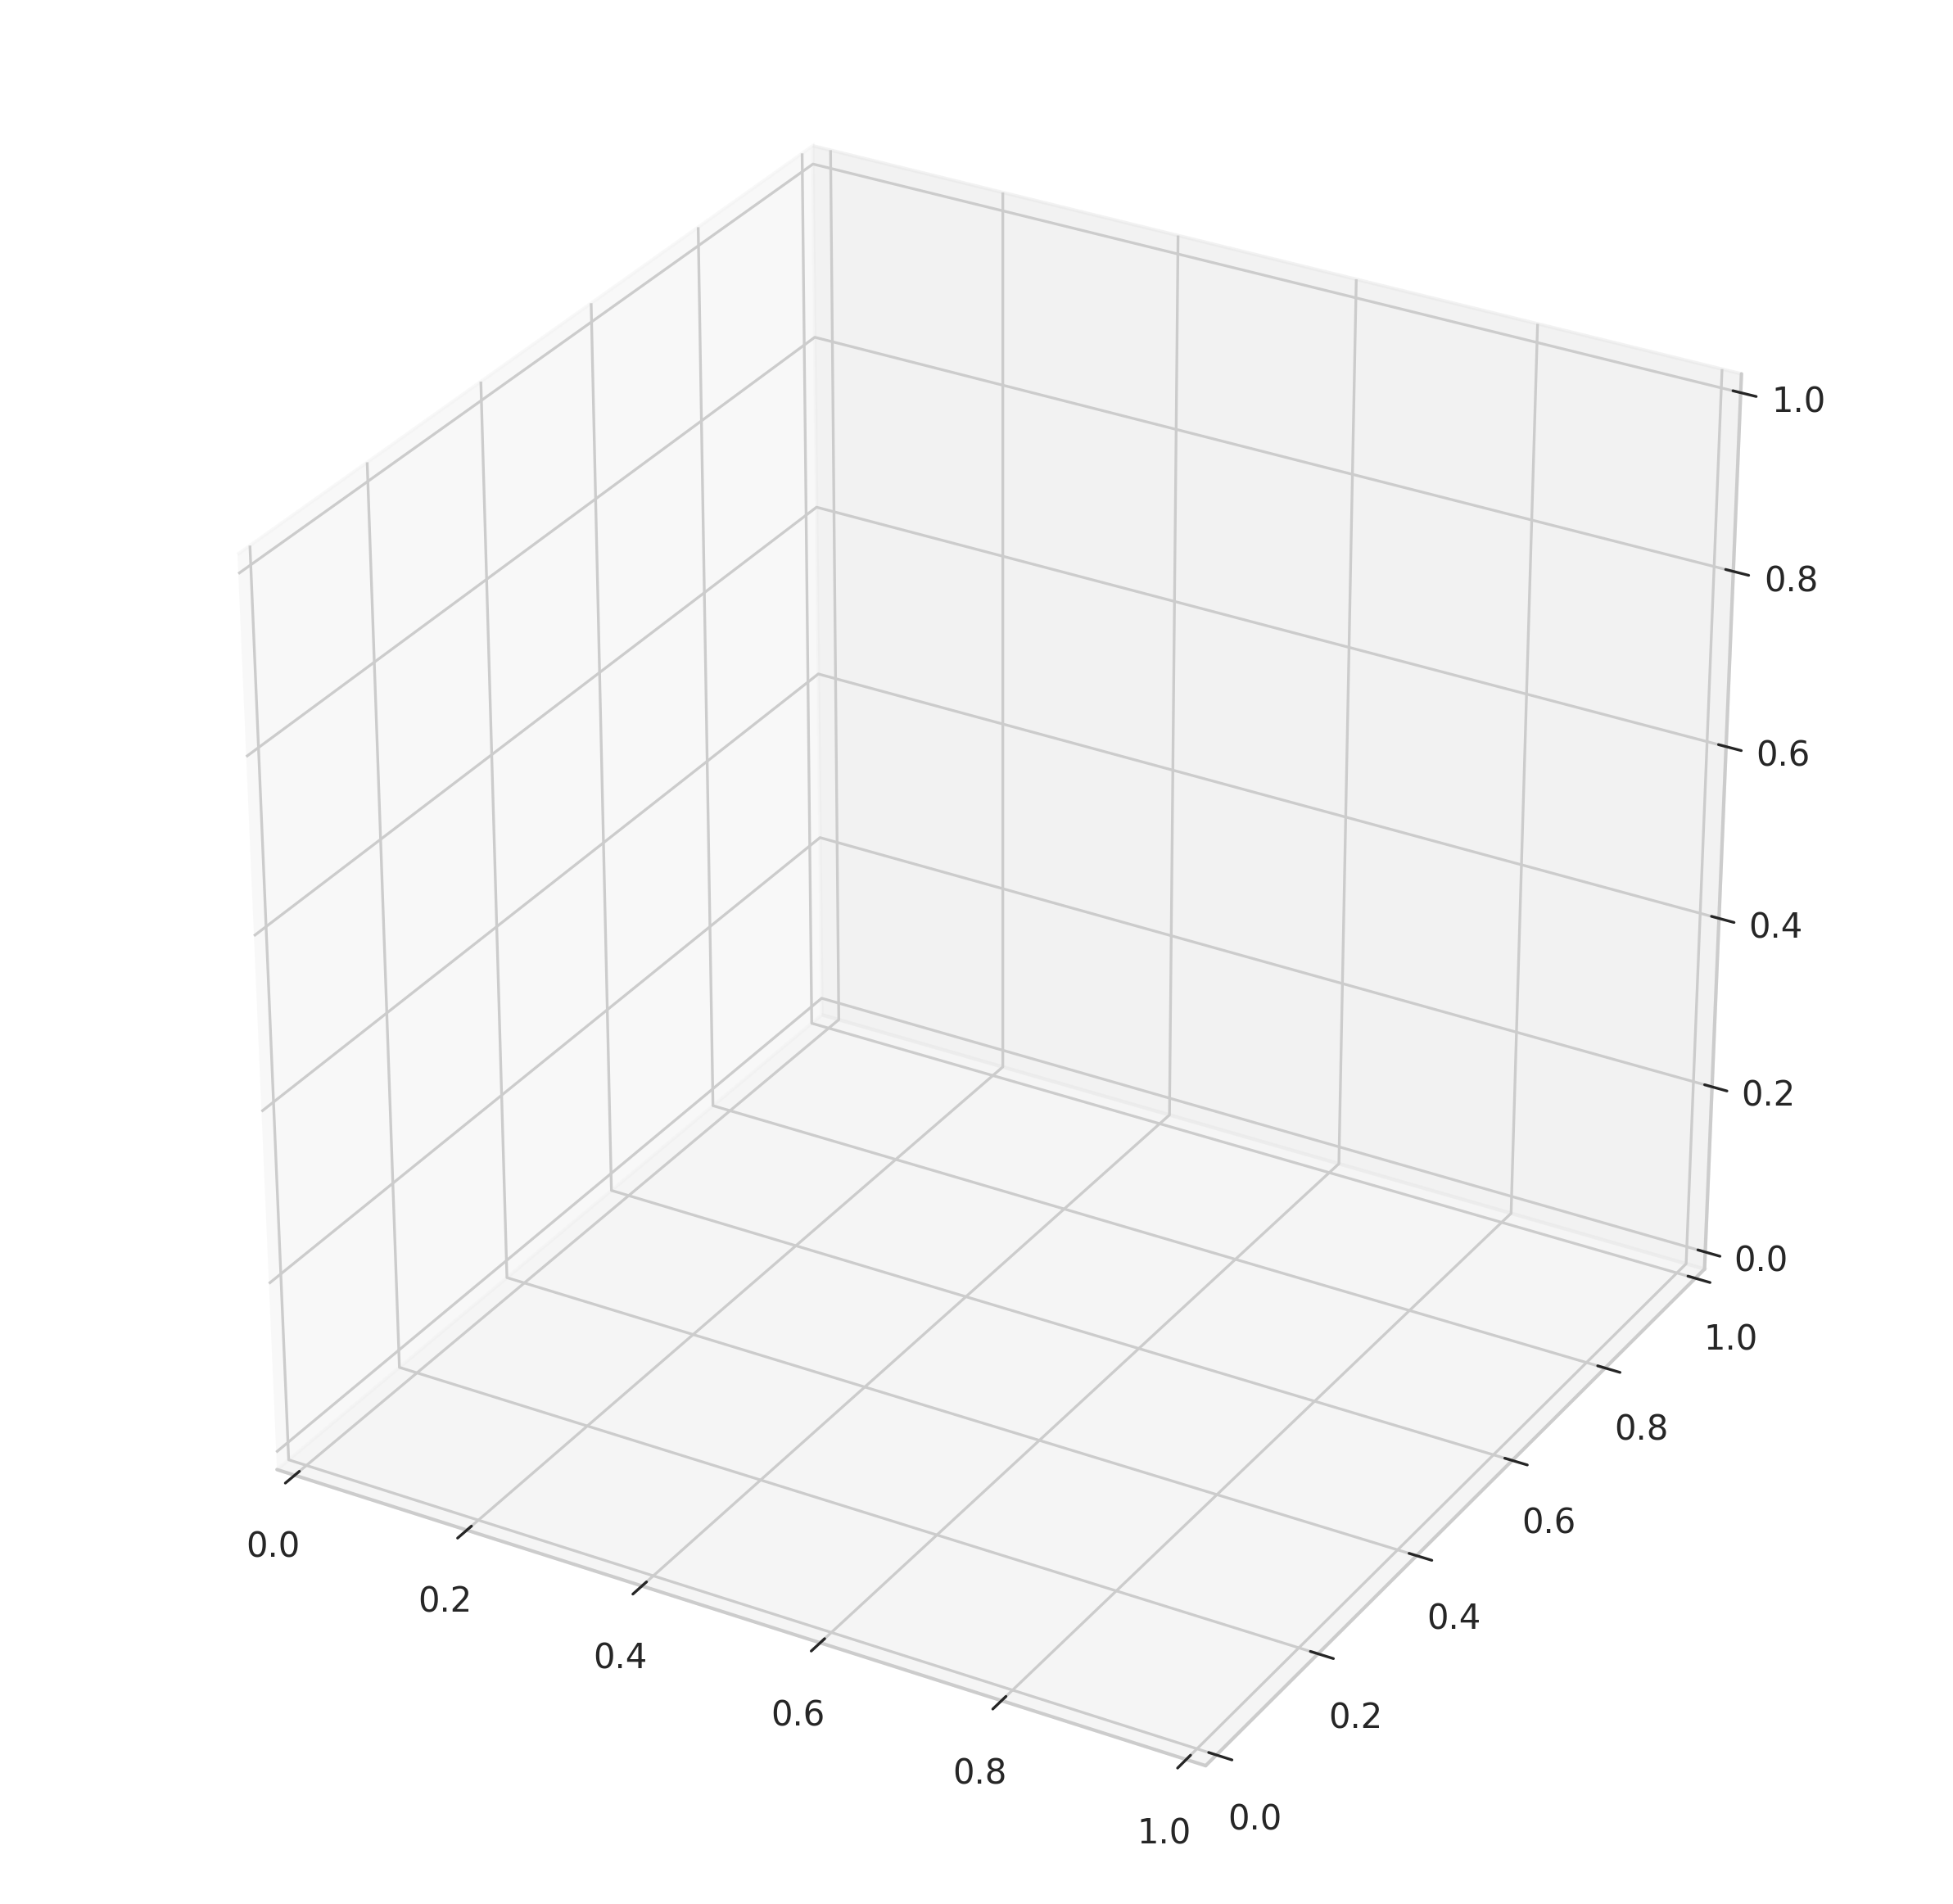

In [24]:
from mpl_toolkits.mplot3d import Axes3D
# if you're loading in a previous file uncomment
df = pd.read_csv('../salty/data/density.csv',delimiter=',')
cols = df.columns
#cols = outer_old.columns
#df = outer_old.loc[outer_old["salt_name"] == "1-ethyl-3-methylimidazolium tetrafluoroborate"]
df = df[cols[[1,2,3]]]
df = df.astype(float)
print(df.describe())

df.reset_index(inplace=True, drop=True)
#df.boxplot()
df.dtypes

with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(10,10), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(df["Temperature, K"],df["Pressure, kPa"] ,
            df["Viscosity, Pa&#8226;s"],linestyle="None", marker="*")
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Pressure')
    ax.set_zlabel('Density')

Dealing with messy data is commonplace. *Even highly vetted data in ILThermo.*

I addressed inaccuracies in the IUPAC naming by first parsing the IUPAC names into two strings (caiton and anion) and then hand checking the strings that had more than two components. I then matched these **weird** IUPAC names to their correct SMILES representations. These are stored in the salty database file cationInfo.csv and anionInfo.csv.

In [22]:
df = pd.read_csv('../salty/data/cpt.csv',delimiter=',')
salts = pd.DataFrame(df["salt_name"])
salts = salts.rename(columns={"salt_name": "salts"})
anions= []
cations= []
missed = 0
for i in range(df.shape[0]):
    if len(salts['salts'].iloc[i].split()) == 2:
        cations.append(salts['salts'].iloc[i].split()[0])
        anions.append(salts['salts'].iloc[i].split()[1])
    elif len(salts['salts'].iloc[i].split()) == 3:
        if("sulfate" in salts['salts'].iloc[i] or\
        "phosphate" in salts['salts'].iloc[i] or\
        "phosphonate" in salts['salts'].iloc[i] or\
        "carbonate" in salts['salts'].iloc[i]):
            #these strings have two-word anions
            first = salts['salts'].iloc[i].split()[1]
            second = salts['salts'].iloc[i].split()[2]
            cations.append(salts['salts'].iloc[i].split()[0])
            anions.append(first + ' ' + second)
        elif("1:1" in salts["salts"].iloc[i]):
            #some strings contain the mixing ratio
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            cations.append(first)
            anions.append(second)
        elif("(OC-6-11)-hexafluoroantimonate(1-)" in salts["salts"].iloc[i]):
            #special case
            cations.append("1-butyl-3-methylimidazolium")
            anions.append("hexafluoroantimonate")
        elif("1,3-propanediol, 2-amino-2-(hydroxymethyl)-," in salts["salts"].iloc[i]):
            #special case
            cations.append("2-amino-2-(hydroxymethyl)-1,3-propanediol")
            anions.append("hydrochloride")
        else:
            #assume the rest are two-word cations
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            third = salts['salts'].iloc[i].split()[2]
            cations.append(first + ' ' + second)
            anions.append(third)
    elif len(salts['salts'].iloc[i].split()) == 4:
        #this particular string block contains (1:1) at end of name
        if("1,1,2,3,3,3-hexafluoro-1-propanesulfonate" in salts['salts'].iloc[i]):
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            cations.append(first + ' ' + second)
            anions.append(salts['salts'].iloc[i].split()[2])
        else:
            #and two word anion
            first = salts['salts'].iloc[i].split()[1]
            second = salts['salts'].iloc[i].split()[2]
            anions.append(first + ' ' + second)
            cations.append(salts['salts'].iloc[i].split()[0])
    elif("2-aminoethanol-2-hydroxypropanoate" in salts['salts'].iloc[i]):
        #one of the ilthermo salts is missing a space between cation/anion
        anions.append("2-hydroxypropanoate")
        cations.append("2-aminoethanol")
    elif len(salts['salts'].iloc[i].split()) == 5:
        if("bis[(trifluoromethyl)sulfonyl]imide" in salts['salts'].iloc[i]):
            anions.append("bis(trifluoromethylsulfonyl)imide")
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            third = salts['salts'].iloc[i].split()[2]
            fourth = salts['salts'].iloc[i].split()[3]
            cations.append(first + ' ' + second + ' ' + third + ' ' + fourth)
        if("trifluoro(perfluoropropyl)borate" in salts['salts'].iloc[i]):
            anions.append("trifluoro(perfluoropropyl)borate")
            cations.append("N,N,N-triethyl-2-methoxyethan-1-aminium")
    elif("1H-imidazolium, 1-ethyl-3-methyl-, salt with trifluoroacetic acid (1:1)"
        in salts['salts'].iloc[i]):
        anions.append("trifluoroacetic acid")
        cations.append("1-ethyl-3-methyl-1H-imidazolium")
    elif("L-alanine, 1-methylethyl ester, dodecyl sulfate (1:1)"
        in salts['salts'].iloc[i]):
        anions.append("dodecyl sulfate")
        cations.append("L-alanine, 1-methylethyl ester")
    elif("difluorogermylene" in salts['salts'].iloc[i]):
        anions.append("difluoro")
        cations.append("germylene")
    else:
        print(salts['salts'].iloc[i])
        missed += 1
anions = pd.DataFrame(anions, columns=["name-anion"])
cations = pd.DataFrame(cations, columns=["name-cation"])
# salts=pd.read_csv('../salty/data/salts_with_smiles.csv',delimiter=',')
# new_df = pd.concat([salts["name-cation"], salts["name-anion"], salts["Temperature, K"],\
#                     salts["Pressure, kPa"], salts["Specific density, kg/m<SUP>3</SUP>"]],\
#                    axis = 1)
print(missed)

0


After appending SMILES to the dataframe, we're ready to add RDKit descriptors. Because the descriptors are specific to a given cation and anion, and there are many repeats of these within the data (~10,000 datapoints with ~300 cations and ~150 anions) it is much faster to use pandas to append existing descriptor dataframes to our growing dataframe from ILThermo.

In [23]:
cationDescriptors = salty.load_data("cationDescriptors.csv")
cationDescriptors.columns = [str(col) + '-cation' for col in cationDescriptors.columns]
anionDescriptors = salty.load_data("anionDescriptors.csv")
anionDescriptors.columns = [str(col) + '-anion' for col in anionDescriptors.columns]

In [27]:
new_df = pd.concat([cations, anions, df["Temperature, K"], df["Pressure, kPa"],\
                    df["Heat capacity at constant pressure, J/K/mol"]], axis=1)
new_df = pd.merge(cationDescriptors, new_df, on="name-cation", how="right")
new_df = pd.merge(anionDescriptors, new_df, on="name-anion", how="right")
new_df.dropna(inplace=True) #remove entries not in smiles database

In [28]:
pd.DataFrame.to_csv(new_df, path_or_buf='../salty/data/MODELS/cpt_premodel.csv', index=False)

<a id='multidevmodel'></a>
# Multi-Output Development Model

[back to top](#top)

**At this point I introduce a new class of objects called devmodel. **

devmodel is a pickle-able object. self.Data contains the scaled/centered feature data and log of the property data as well as the original IUPAC names and SMILES. This makes it easy to consistently unpickle the devmodel and begin using it in an sklearn algorithm without making changes to the dataframe. Self.Coef_data contains the mean and standard deviation of the features so that structure candidates in our genetic algorithm can be scaled and centered appropriately.

It is important to make any addition subselections of the dataset before you scale and center the data - this is the purpose of the cells bellow.

In [65]:
visc = pd.read_csv('../salty/data/MODELS/cpt_premodel.csv')
dens = pd.read_csv('../salty/data/MODELS/density_premodel.csv')

In [66]:
df = pd.merge(visc, dens, 
                  #on=["name-cation", "name-anion", "Temperature, K", "Pressure, kPa"],
                  sort=False, how="outer")
df.dropna(inplace=True) #remove entries not in smiles database

In [67]:
df.shape

(7834, 196)

In [11]:
dens[["name-cation", "name-anion", "Temperature, K", "Pressure, kPa",
        "Specific density, kg/m<SUP>3</SUP>"]]

,name-cation,name-anion,"Temperature, K","Pressure, kPa","Specific density, kg/m<SUP>3</SUP>"
0,1-butyl-2-methylpyridinium,tetrafluoroborate,298.15,101.325,1201.14
1,1-butyl-2-methylpyridinium,tetrafluoroborate,298.15,101.325,1202.20
2,1-butyl-2-methylpyridinium,tetrafluoroborate,298.15,101.325,1202.50
3,1-butyl-2-methylpyridinium,tetrafluoroborate,298.15,101.325,1201.38
4,1-butyl-2-methylpyridinium,tetrafluoroborate,298.15,101.325,1202.17
5,1-butyl-2-methylpyridinium,tetrafluoroborate,318.15,101.325,1188.71
6,1-butyl-2-methylpyridinium,tetrafluoroborate,298.15,101.325,1201.67
7,1-butyl-2-methylpyridinium,tetrafluoroborate,318.15,101.325,1188.29
8,1-butyl-2-methylpyridinium,tetrafluoroborate,288.00,101.325,1207.41
9,1-butyl-2-methylpyridinium,tetrafluoroborate,298.00,101.325,1200.55


In [12]:
visc[["name-cation", "name-anion", "Temperature, K", "Pressure, kPa",
        "Viscosity, Pa&#8226;s"]]

,name-cation,name-anion,"Temperature, K","Pressure, kPa","Viscosity, Pa&#8226;s"
0,1-butyl-2-methylpyridinium,tetrafluoroborate,298.15,101.325,0.25000
1,1-butyl-2-methylpyridinium,tetrafluoroborate,298.15,101.325,0.40300
2,1-butyl-2-methylpyridinium,tetrafluoroborate,318.15,101.325,0.09990
3,1-butyl-2-methylpyridinium,tetrafluoroborate,288.00,101.325,0.98600
4,1-butyl-2-methylpyridinium,tetrafluoroborate,298.00,101.325,0.45000
5,1-butyl-2-methylpyridinium,tetrafluoroborate,308.00,101.325,0.21580
6,1-butyl-2-methylpyridinium,tetrafluoroborate,318.00,101.325,0.10850
7,1-butyl-2-methylpyridinium,tetrafluoroborate,328.00,101.325,0.05690
8,1-butyl-2-methylpyridinium,tetrafluoroborate,288.15,101.325,0.86000
9,1-butyl-2-methylpyridinium,tetrafluoroborate,290.65,101.325,0.69000


In [12]:
df[["name-cation", "name-anion", "Temperature, K", "Pressure, kPa",
        "Viscosity, Pa&#8226;s", "Specific density, kg/m<SUP>3</SUP>"]]

,name-cation,name-anion,"Temperature, K","Pressure, kPa","Viscosity, Pa&#8226;s","Specific density, kg/m<SUP>3</SUP>"
0,1-butyl-2-methylpyridinium,tetrafluoroborate,298.15,101.325,0.2500,1201.14
1,1-butyl-2-methylpyridinium,tetrafluoroborate,298.15,101.325,0.2500,1202.20
2,1-butyl-2-methylpyridinium,tetrafluoroborate,298.15,101.325,0.2500,1202.50
3,1-butyl-2-methylpyridinium,tetrafluoroborate,298.15,101.325,0.2500,1201.38
4,1-butyl-2-methylpyridinium,tetrafluoroborate,298.15,101.325,0.2500,1202.17
5,1-butyl-2-methylpyridinium,tetrafluoroborate,298.15,101.325,0.2500,1201.67
6,1-butyl-2-methylpyridinium,tetrafluoroborate,298.15,101.325,0.2500,1201.40
7,1-butyl-2-methylpyridinium,tetrafluoroborate,298.15,101.325,0.4030,1201.14
8,1-butyl-2-methylpyridinium,tetrafluoroborate,298.15,101.325,0.4030,1202.20
9,1-butyl-2-methylpyridinium,tetrafluoroborate,298.15,101.325,0.4030,1202.50


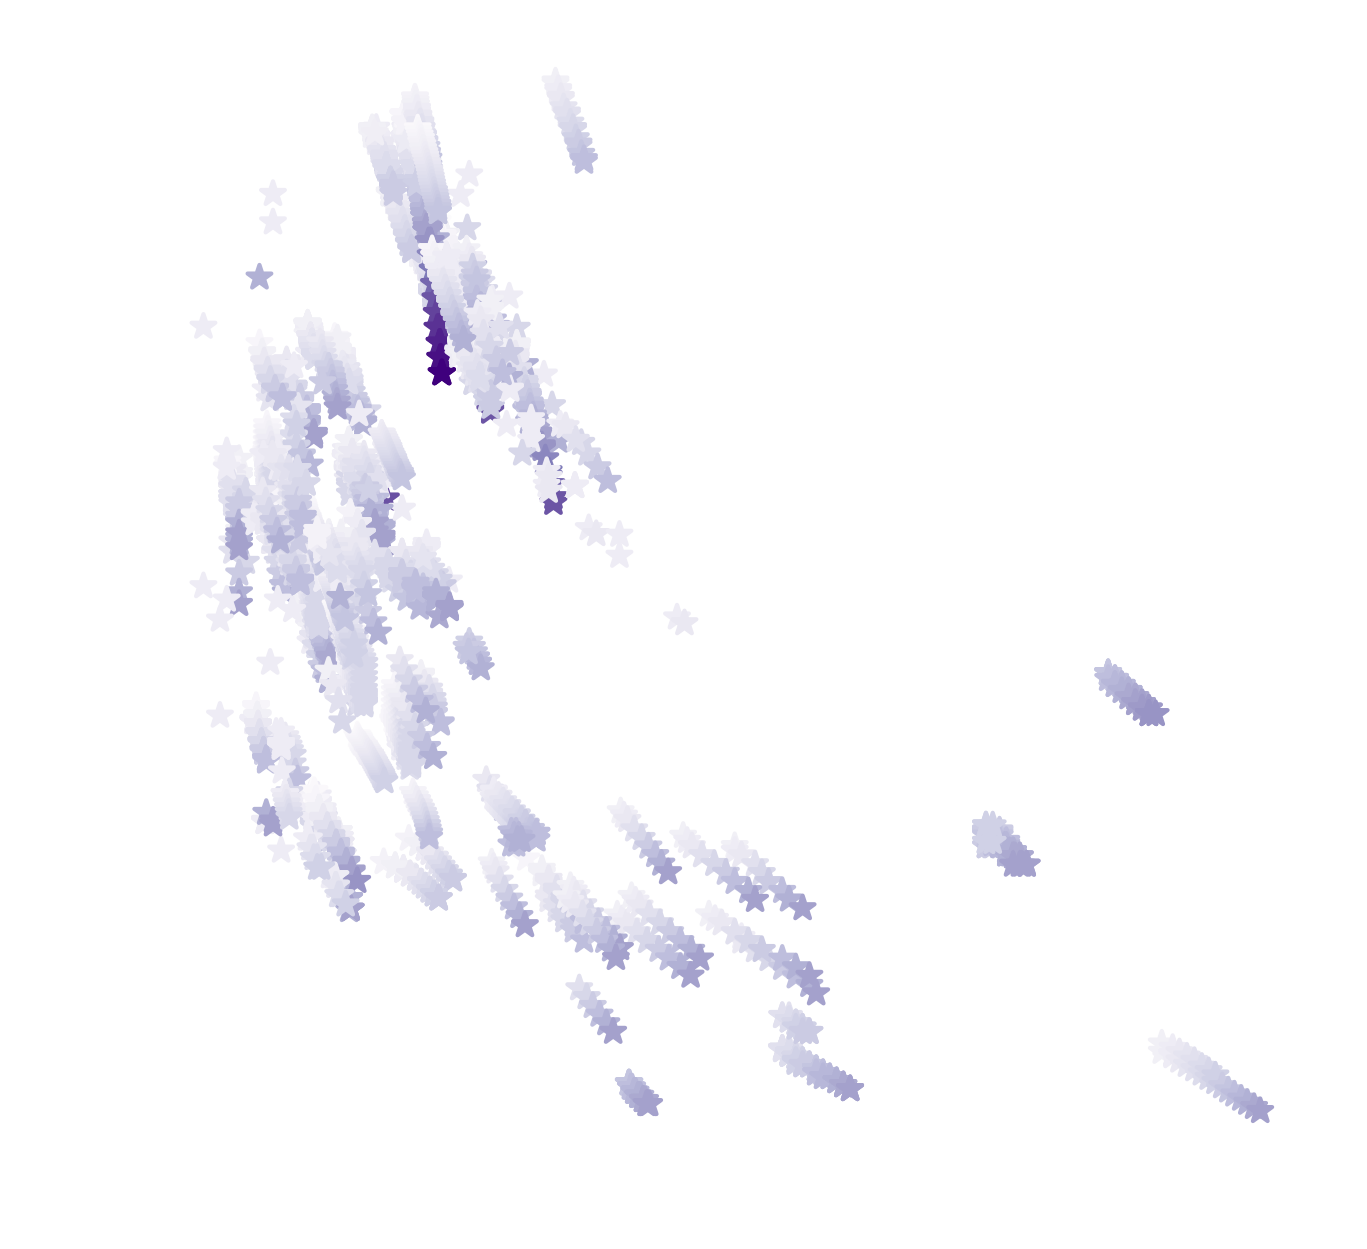

In [43]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,5), dpi=300)
    ax=fig.add_subplot(111)
    ax.scatter(df["Heat capacity at constant pressure, J/K/mol"], df["Specific density, kg/m<SUP>3</SUP>"],
        marker="*", c=df["Temperature, K"]/max(df["Temperature, K"]), cmap="Purples")
    ax.grid()
    ax.set_axis_off()
#     ax.set_xlim(0,.1)
#     ax.set_ylim(0,2)
#     ax.text(0.1,.9,"R: {0:10.3f}".format(model.score(X,Y)), transform = ax.transAxes)
# fig.savefig(filename='../../designer_molecules/11.png', 
#                        bbox_inches='tight', format='png', transparent=True) 

<a id='devmodel'></a>
# Development Model

[back to top](#top)

In [5]:
property_model = "density"
df = pd.DataFrame.from_csv('../salty/data/MODELS/%s_premodel.csv' % property_model, index_col=None)
df.shape

(28952, 195)

In [6]:
###Make any subselections of the data here
#Specific density, kg/m<SUP>3</SUP> density key
#Viscosity, Pa&#8226;s viscosity key
down_select = df
#down_select = down_select.loc[down_select["name-anion"].str.contains("2-(2-methoxyethoxy)ethyl sulfate")]
# down_select = down_select.loc[down_select["Temperature, K"] < 315]
down_select = down_select.loc[down_select["Temperature, K"] > 0]
# down_select = down_select.loc[down_select["Pressure, kPa"] < 200]
# down_select = down_select.loc[down_select["Pressure, kPa"] > 100]
#down_select = down_select.loc[down_select["Specific density, kg/m<SUP>3</SUP>"] < 1]
# down_select = down_select.loc[down_select["Viscosity, Pa&#8226;s"] > 1]

unique_salts = down_select["smiles-cation"] + down_select["smiles-anion"]
unique_cations = repr(down_select["smiles-cation"].unique())
unique_anions = repr(down_select["smiles-anion"].unique())
temp_range = str(down_select["Temperature, K"].min()) + " - " + \
             str(down_select["Temperature, K"].max()) + " K"
pres_range = str(down_select["Pressure, kPa"].min()) + " - " + \
             str(down_select["Pressure, kPa"].max()) + " kPa"
# visc_range = str(down_select["Heat capacity at constant pressure, J/K/mol"].min()) + " - " + \
#              str(down_select["Heat capacity at constant pressure, J/K/mol"].max()) + " J/K/mol" 
dens_range = str(down_select["Specific density, kg/m<SUP>3</SUP>"].min()) + " - " + \
             str(down_select["Specific density, kg/m<SUP>3</SUP>"].max()) + " kg/m3"    
a = np.array([len(unique_salts.unique()), unique_cations, unique_anions, len(unique_salts), 
              temp_range, pres_range, dens_range])
cols = ["Unique salts", "Cations", "Anions", "Total datapoints", "Temperature range",
        "Pressure range", "Density range"]
data_summary = pd.DataFrame(a, cols)
data_summary

,0
Unique salts,502
Cations,"array(['CCCC[n+]1ccc(cc1)C', 'CCCn1cc[n+](c1C)..."
Anions,"array(['[B-](F)(F)(F)F', 'F[P-](F)(F)(F)(F)F',..."
Total datapoints,28952
Temperature range,217.577 - 473.15 K
Pressure range,86.5 - 300000.0 kPa
Density range,841.3 - 1741.5 kg/m3


In [7]:
down_select.reset_index(drop=True, inplace=True)
df = down_select

In [8]:
property_model = "density"

In [10]:
import dill

In [12]:
metaDf = df.select_dtypes(include=["object"])
dataDf = df.select_dtypes(include=[np.number])
#property_scale = dataDf["Heat capacity at constant pressure, J/K/mol"].apply(lambda x: log(float(x)))
property_scale2 = dataDf["Specific density, kg/m<SUP>3</SUP>"].apply(lambda x: log(float(x)))
cols = dataDf.columns.tolist()
instance = StandardScaler()
data = pd.DataFrame(instance.fit_transform(dataDf.iloc[:,:-2]), columns=cols[:-2])
df = pd.concat([data, property_scale2, metaDf], axis=1)
mean_std_of_coeffs = pd.DataFrame([instance.mean_,instance.scale_], columns=cols[:-2])
devmodel = dev_model(mean_std_of_coeffs, data_summary, df)
pickle_out = open("../salty/data/MODELS/%s_devmodel.pkl" % property_model, "wb")
dill.dump(devmodel, pickle_out)
pickle_out.close()

<a id='multi'></a>

# Multi Output Regressor

[back to top](#top)

In [74]:
property_model = "density"
pickle_in = open("../salty/data/MODELS/%s_devmodel.pkl" % property_model, "rb")
devmodel = pickle.load(pickle_in)
rawdf = devmodel.Data
rawdf = rawdf.sample(frac=1)
metadf = rawdf.select_dtypes(include=["object"])
datadf = rawdf.select_dtypes(include=[np.number])

data=np.array(datadf)

n = data.shape[0]
d = data.shape[1]
d -= 2
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train,2))
Y_test = np.zeros((n_test,2))
X_train[:] = data[:n_train,:-2] #fill arrays according to train/test split
Y_train[:] = (data[:n_train,-2:].astype(float))
X_test[:] = data[n_train:,:-2]
Y_test[:] = (data[n_train:,-2:].astype(float))

In [75]:
#Density Model Settings
model = MLPRegressor(activation='logistic', alpha=0.92078, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=75, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1e8, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)
#Viscosity Model Settings
# model = MLPRegressor(activation='tanh', alpha=0.65795591411979337, batch_size='auto',
#        beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
#        hidden_layer_sizes=25, learning_rate='invscaling',
#        learning_rate_init=0.001, max_iter=100000, momentum=0.9,
#        nesterovs_momentum=True, power_t=0.5, random_state=None,
#        shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
#        verbose=False, warm_start=False)
multi_model = MultiOutputRegressor(model)
multi_model.fit(X_train,Y_train)
multi_model.score(X_train,Y_train)

0.99073490313109824

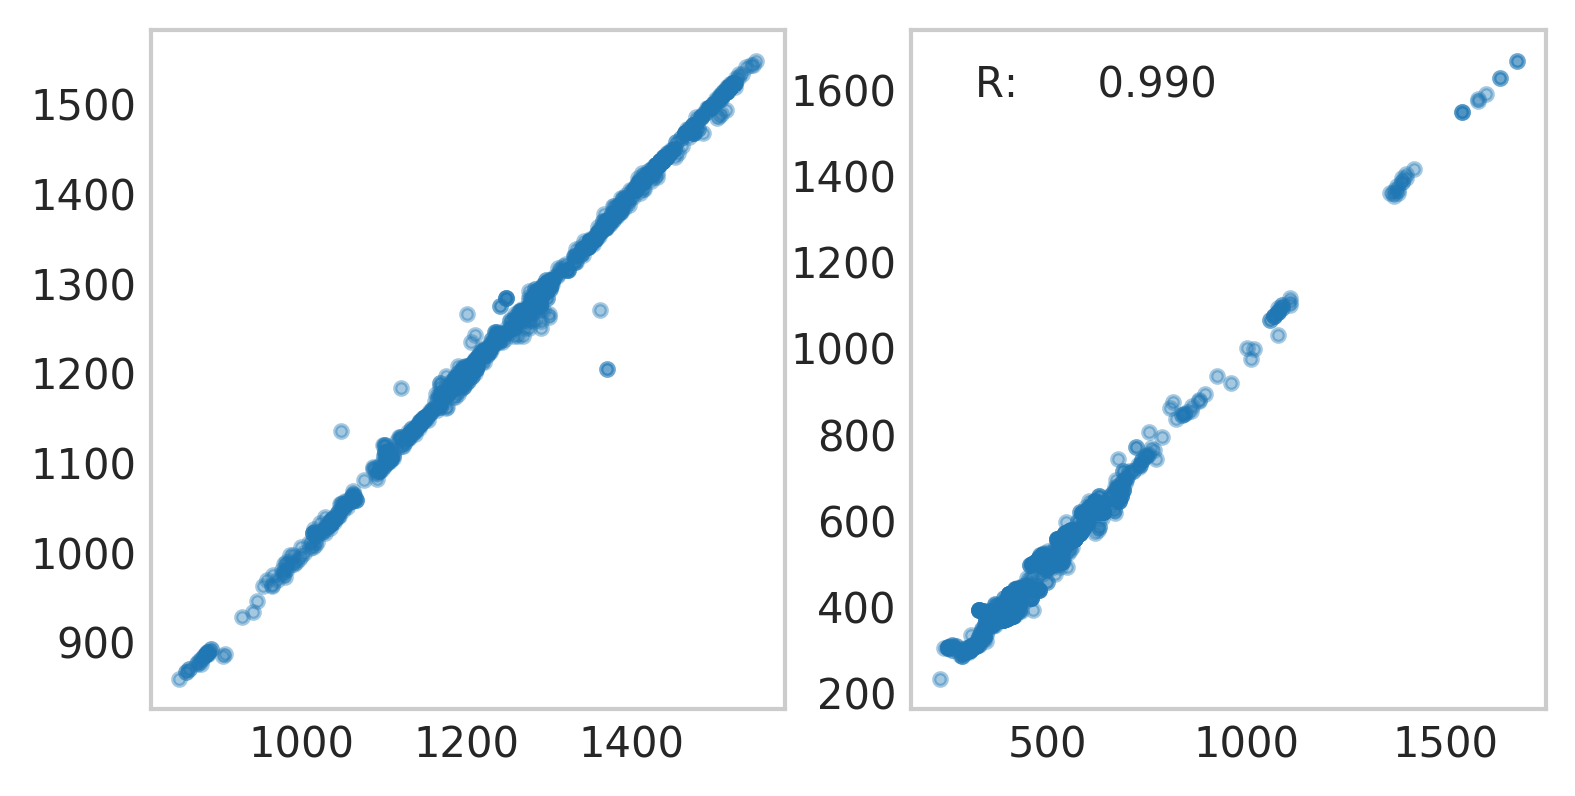

In [76]:
X=X_test
Y=Y_test
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(6,3), dpi=300)
    ax=fig.add_subplot(121)
    ax.plot(np.exp(Y)[:,1],np.exp(multi_model.predict(X))[:,1],\
            marker=".",linestyle="",alpha=0.4)
    ax.grid()
    ax=fig.add_subplot(122)
    ax.plot(np.exp(Y)[:,0],np.exp(multi_model.predict(X))[:,0],\
            marker=".",linestyle="",alpha=0.4)
    ax.grid()
#     ax.set_xlim(0,2)
#     ax.set_ylim(0,2)
    ax.text(0.1,.9,"R: {0:10.3f}".format(multi_model.score(X,Y)), transform = ax.transAxes)
# fig.savefig(filename='../../designer_molecules/9.eps', 
#                        bbox_inches='tight', format='eps') 

<a id='nn'></a>

# MLPRegressor

[back to top](#top)

In [44]:
property_model = "cpt"
pickle_in = open("../salty/data/MODELS/%s_devmodel.pkl" % property_model, "rb")
devmodel = pickle.load(pickle_in)
rawdf = devmodel.Data
rawdf = rawdf.sample(frac=1)
metadf = rawdf.select_dtypes(include=["object"])
datadf = rawdf.select_dtypes(include=[np.number])

data=np.array(datadf)

n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))
X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
Y_train[:] = (data[:n_train,-1].astype(float))
X_test[:] = data[n_train:,:-1]
Y_test[:] = (data[n_train:,-1].astype(float))

I usually optimize my MLP regressor hyper parameters with any new type of dataset. This takes a long time to run so I use the Hyak supercomputer.

In [73]:
###Randomized Search NN Characterization
param_grid = {"activation": ["identity", "logistic", "tanh", "relu"],\
             "solver": ["lbfgs", "sgd", "adam"], "alpha": sp_rand(),\
             "learning_rate" :["constant", "invscaling", "adaptive"],\
             "hidden_layer_sizes": [randint(100)]}

model = MLPRegressor(max_iter=100000, tol=1e-8)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,\
                          n_jobs=-1, n_iter=10)
grid_result = grid.fit(X_train, Y_train)

print(grid_result.best_estimator_)

/home/wesley/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/wesley/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/wesley/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='tanh', alpha=0.65795591411979337, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=25, learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=100000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)


In [45]:
#Density Model Settings
model = MLPRegressor(activation='logistic', alpha=0.92078, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=75, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1e8, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)
#Viscosity Model Settings
# model = MLPRegressor(activation='tanh', alpha=0.65795591411979337, batch_size='auto',
#        beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
#        hidden_layer_sizes=25, learning_rate='invscaling',
#        learning_rate_init=0.001, max_iter=100000, momentum=0.9,
#        nesterovs_momentum=True, power_t=0.5, random_state=None,
#        shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
#        verbose=False, warm_start=False)
model.fit(X_train,Y_train)
model.score(X_train,Y_train)

0.98113722292949102

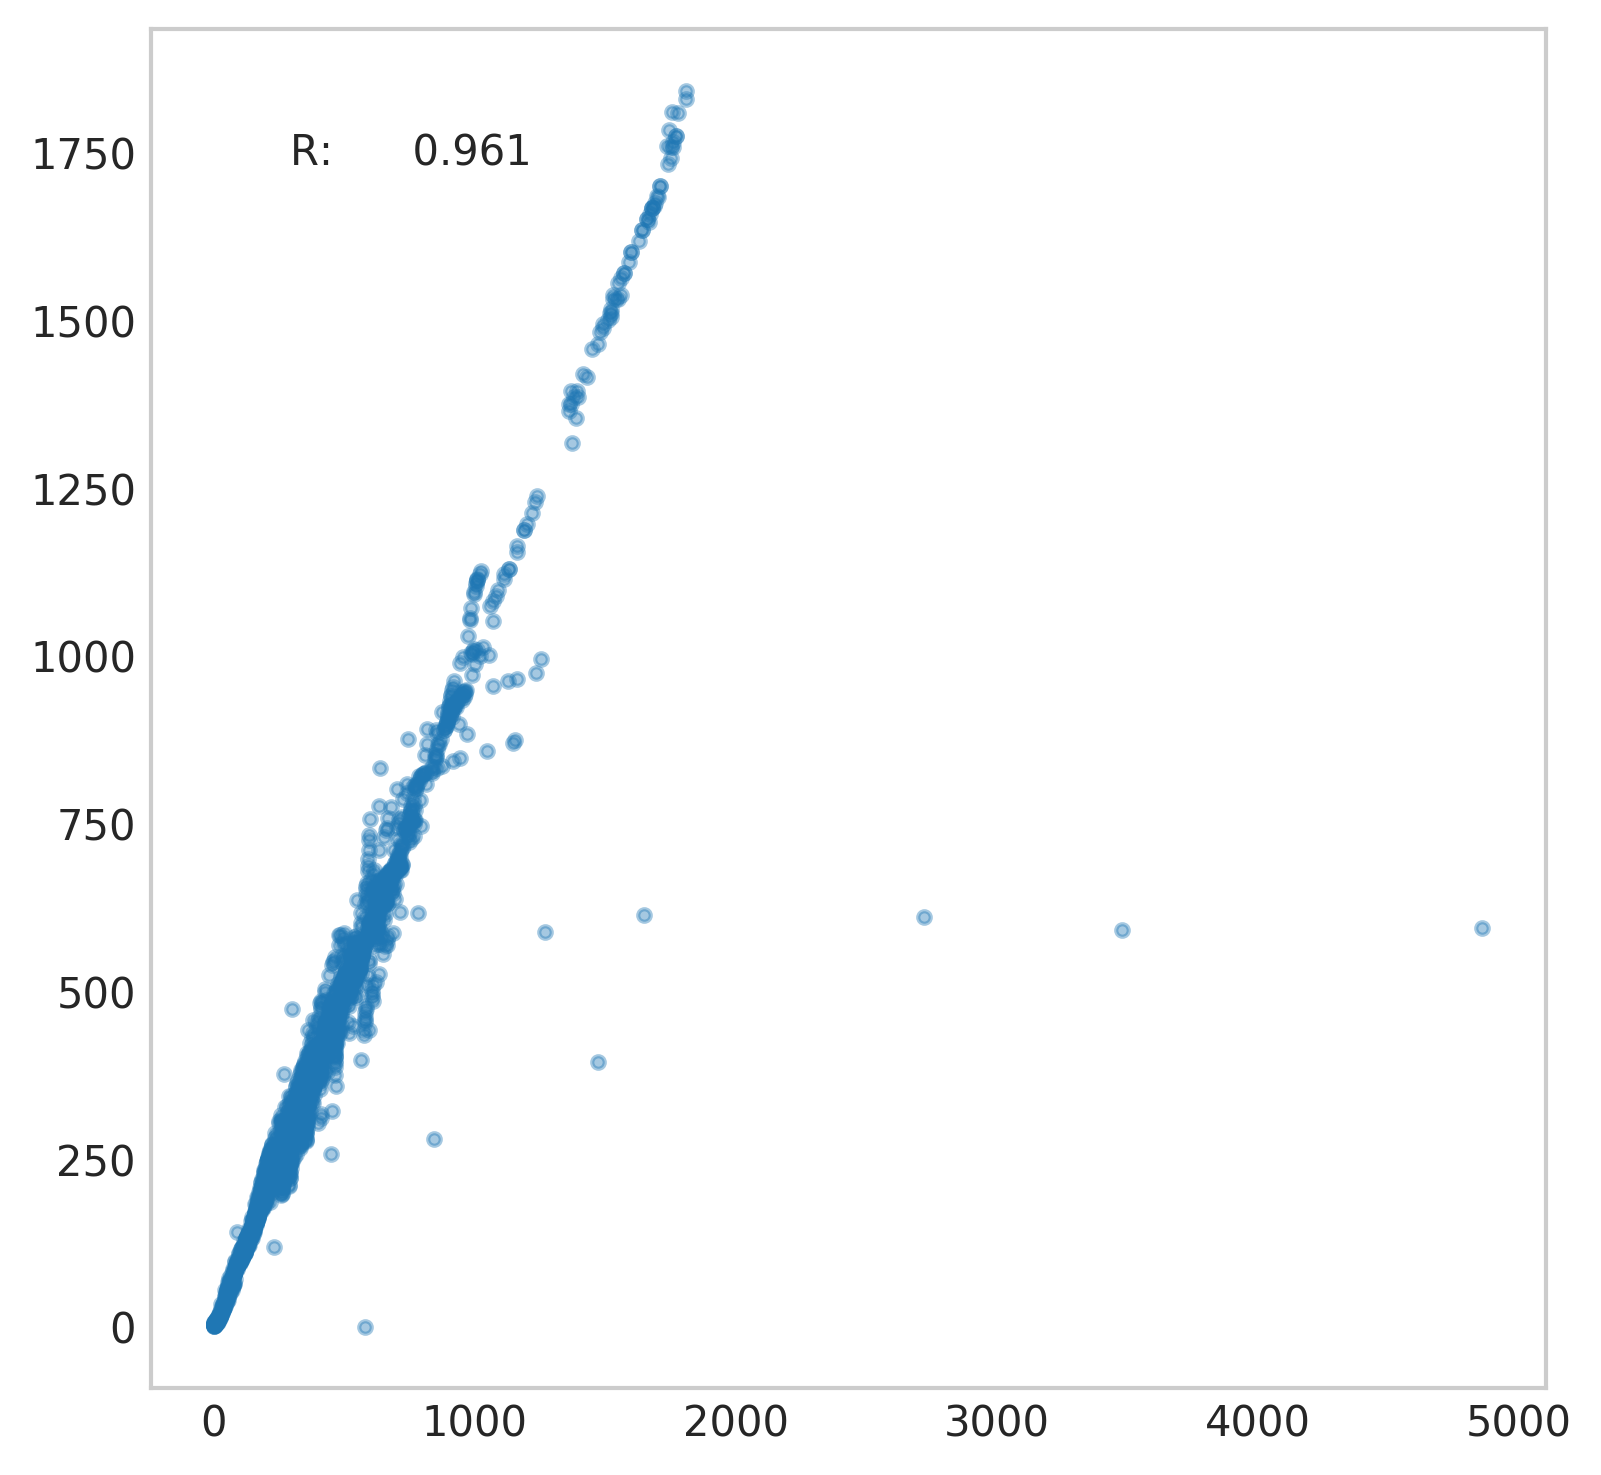

In [46]:
X=X_test
Y=Y_test
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(6,6), dpi=300)
    ax=fig.add_subplot(111)
    ax.plot(np.exp(Y),np.exp(model.predict(X)),\
            marker=".",linestyle="",alpha=0.4)
    ax.grid()
#     ax.set_xlim(0,2)
#     ax.set_ylim(0,2)
    ax.text(0.1,.9,"R: {0:10.3f}".format(model.score(X,Y)), transform = ax.transAxes)

<a id='static'></a>

# Save the final model to be used in the [GAINS](https://github.com/wesleybeckner/gains) fitness test

[back to top](#top)

In [77]:
model = multi_model

In [84]:
pickle_out = open("../salty/data/MODELS/cpt_density_m1.sav", "wb")
pickle.dump(model, pickle_out)
pickle_out.close()

summ = devmodel.Data_summary
a = pd.DataFrame.from_dict(model.get_params(), orient='index')
b = pd.DataFrame([model.score(X_train,Y_train)], columns=["train score"])
c = pd.DataFrame([model.score(X_test,Y_test)], columns=["test score"])
d = pd.concat([summ, a, b.T, c.T])
pd.DataFrame.to_csv(d, path_or_buf=
                   '../salty/data/MODELS/cpt_density_m1_summary.csv', index=True)
coeffs = devmodel.Coef_data
pd.DataFrame.to_csv(coeffs, path_or_buf=
                    '../salty/data/MODELS/cpt_density_m1_descriptors.csv', index=False)

In [85]:
pd.read_csv("../salty/data/MODELS/cpt_density_m1_summary.csv")

,Unnamed: 0,0
0,Unique salts,109
1,Cations,"array(['CCCC[n+]1ccc(cc1)C', 'CCCCCCCCn1cc[n+]..."
2,Anions,"array(['[B-](F)(F)(F)F', 'F[P-](F)(F)(F)(F)F',..."
3,Total datapoints,7834
4,Temperature range,273.15 - 463.15 K
5,Pressure range,100.0 - 60000.0 kPa
6,Cpt range,207.47 - 1764.0 J/K/mol
7,Density range,847.5 - 1557.1 J/K/mol
8,estimator__activation,logistic
9,estimator__alpha,0.92078


<a id='adaptive'></a>

# Adaptive Learning

[back to top](#top)

In [2]:
property_model = "density"
pickle_in = open("../salty/data/MODELS/%s_devmodel.pkl" % property_model, "rb")
devmodel = pickle.load(pickle_in)
rawdf = devmodel.Data
rawdf = rawdf.sample(frac=1)
metadf = rawdf.select_dtypes(include=["object"])
datadf = rawdf.select_dtypes(include=[np.number])

data=np.array(datadf)

n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))
X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
Y_train[:] = (data[:n_train,-1].astype(float))
X_test[:] = data[n_train:,:-1]
Y_test[:] = (data[n_train:,-1].astype(float))